In [1]:
import os
os.chdir("../")

In [203]:
%load_ext autoreload
%autoreload 2

In [273]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prior import VQVAEPrior
from experiment import VAEXperiment

from easydict import EasyDict as edict
from analysis.image import show_image
from datamodules import DATAMODULES

from tqdm import tqdm

from likelihood import (
    compute_log_likelihood, 
    compute_log_likelihood_v2, 
    compute_dataset_log_likelihood,
    compute_dataset_log_likelihood_batched,
    get_perplexity,
    get_dataset_perplexity,
    compute_codebook_usage_distribution,
    extract_distances_to_probs,
    compute_codebook_usage_distribution_2gram,
    extract_distances_to_probs_2gram
)

# Load Prior Model

In [320]:
prior_ckpt_path = "model_logs/prior/pixel_cnn/CIFAR10/pixel_cnn_256_32/best.ckpt"
prior_ckpt = torch.load(prior_ckpt_path, map_location="cpu")
prior_hparams = edict(prior_ckpt["hyper_parameters"])
prior = VQVAEPrior(prior_hparams)
prior.load_state_dict(prior_ckpt["state_dict"])



Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


<All keys matched successfully>

In [321]:

_ = prior.cuda()
_ = prior.eval()

In [5]:
samples = prior.generate_samples(batch_size=40)

In [6]:
prior_hparams

{'MODEL': {'NAME': 'PixelCNN',
  'INPUT_DIM': 512,
  'DIM': 64,
  'N_LAYERS': 15,
  'N_CLASSES': 10},
 'SOLVER': {'LR': 0.0003,
  'WEIGHT_DECAY': 0.0,
  'BATCH_SIZE': 256,
  'PRECISION': 32,
  'MAX_EPOCHS': 15,
  'NUM_WORKERS': 20},
 'VQ_VAE': {'CKPT_PATH': 'model_logs/codebook/CIFAR10/codebook_512_32/last.ckpt'},
 'DATA': {'ROOT': '/home/nazir/datasets',
  'NAME': 'CIFAR10',
  'NORMALIZATION': 'custom',
  'MEAN': [0.5, 0.5, 0.5],
  'STD': [1.0, 1.0, 1.0],
  'NUM_CLASSES': 10,
  'CLS_SUBSET': None},
 'WANDB': {'ACTIVATE': True,
  'RUN_NAME': 'pixel_cnn_test',
  'PROJECT': 'prior_pixel_cnn',
  'NUM_LOG_IMGS': 40,
  'LOG_DIR': 'logs/prior_pixel_cnn/'},
 'CKPT': {'DIR_PATH': 'model_logs/prior/pixel_cnn/', 'EVERY_N_EPOCHS': 50},
 'RANDOM_SEED': 2000}

# Datasets

In [7]:
import torchvision.transforms as T
from torchvision.datasets import CIFAR10, SVHN, Omniglot, CelebA



In [166]:
datasets_root = "/home/nazir/datasets"

transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])


transform_omniglot = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Resize(32),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])

transform_celeba = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])


cifar_train = CIFAR10(root=datasets_root, train=True, download=True, transform=transform_cifar)
cifar_test = CIFAR10(root=datasets_root, train=False, download=True, transform=transform_cifar)

svhn_test = SVHN(root=datasets_root, split="test", download=True, transform=transform_cifar)
omniglot_test = Omniglot(root=datasets_root, background=True, download=True, transform=transform_omniglot)
celeba_test = CelebA(root=datasets_root, split="test", download=True, transform=transform_celeba)

test_datasets = edict(
    CIFAR10=cifar_test,
    SVHN=svhn_test,
    Omniglot=omniglot_test, 
    CelebA=celeba_test
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Validating Likelihood Computation

**conclusion** : both versions of likelihood are the same, however, v2 is normalized by the number of input tokens and is negative, that's all.

In [80]:
x, y = cifar_test[0]

In [16]:
likelihood = compute_log_likelihood(prior, x, y)
likelihood_v2 = compute_log_likelihood_v2(prior, x, y)

In [18]:
likelihood / 64, likelihood_v2

(tensor([-5.5615], device='cuda:0'), tensor(5.5615, device='cuda:0'))

# Compute Likelihoods

In [322]:
cifar_likelihoods = compute_dataset_log_likelihood(prior, cifar_test)
svhn_likelihoods = compute_dataset_log_likelihood(prior, svhn_test)
omniglot_likelihoods = compute_dataset_log_likelihood(prior, omniglot_test, arbitrary_cls=0)
celeba_likelihoods = compute_dataset_log_likelihood(prior, celeba_test, arbitrary_cls=0)

100%|██████████| 10000/10000 [01:30<00:00, 110.09it/s]


In [323]:
# divide the log-likelihoods by 64 to get the log-likelihoods per pixel
cifar_likelihoods_per_pixel = cifar_likelihoods / 64
svhn_likelihoods_per_pixel = svhn_likelihoods / 64
omniglot_likelihoods_per_pixel = omniglot_likelihoods / 64
celeba_likelihoods_per_pixel = celeba_likelihoods / 64

Text(0.5, 1.0, 'Log Likelihoods (nats/dim)')

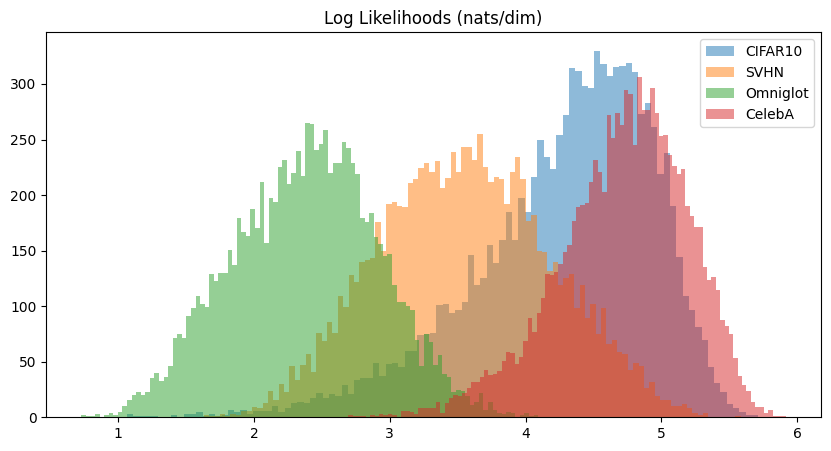

In [324]:
# plot the densities of the liklihoods per pixel
plt.figure(figsize=(10, 5))
plt.hist(cifar_likelihoods_per_pixel, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(svhn_likelihoods_per_pixel, bins=100, alpha=0.5, label="SVHN")
plt.hist(omniglot_likelihoods_per_pixel, bins=100, alpha=0.5, label="Omniglot")
plt.hist(celeba_likelihoods_per_pixel, bins=100, alpha=0.5, label="CelebA")
plt.legend()
plt.title("Log Likelihoods (nats/dim)")

## Check effect of different conditioning for OoD Datasets

100%|██████████| 10000/10000 [01:23<00:00, 119.55it/s]


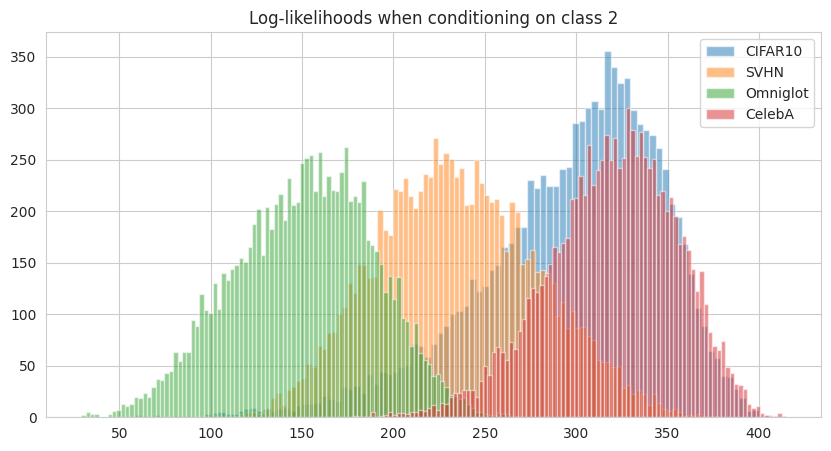

100%|██████████| 10000/10000 [01:24<00:00, 118.43it/s]


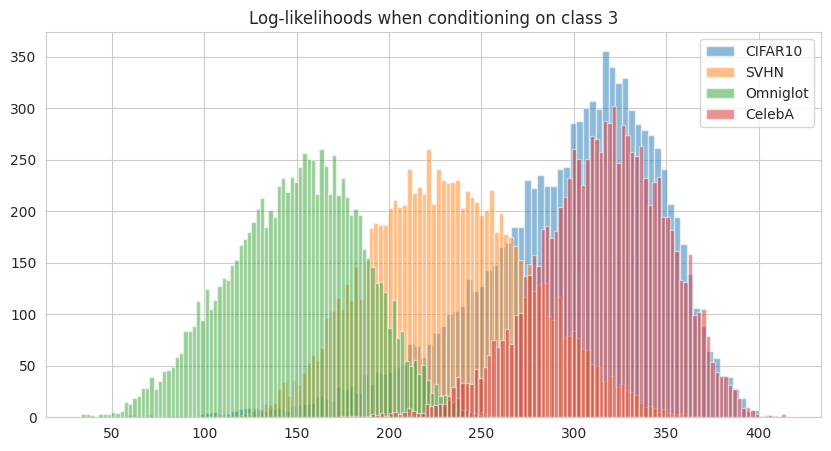

100%|██████████| 10000/10000 [01:24<00:00, 118.28it/s]


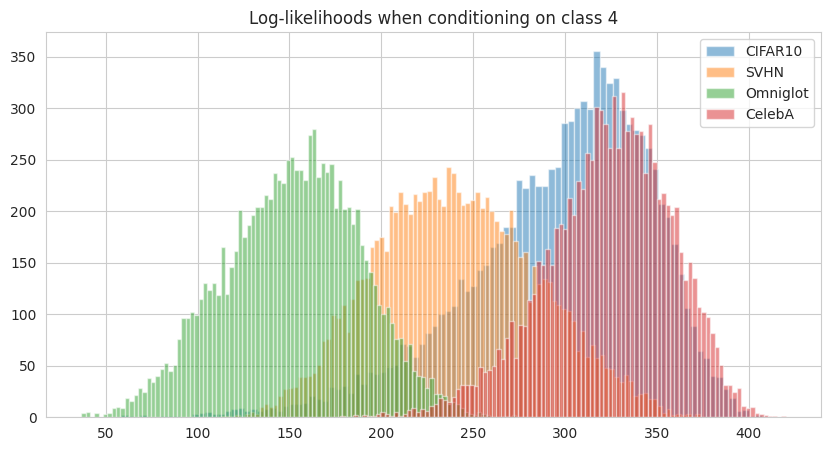

100%|██████████| 10000/10000 [01:27<00:00, 114.25it/s]


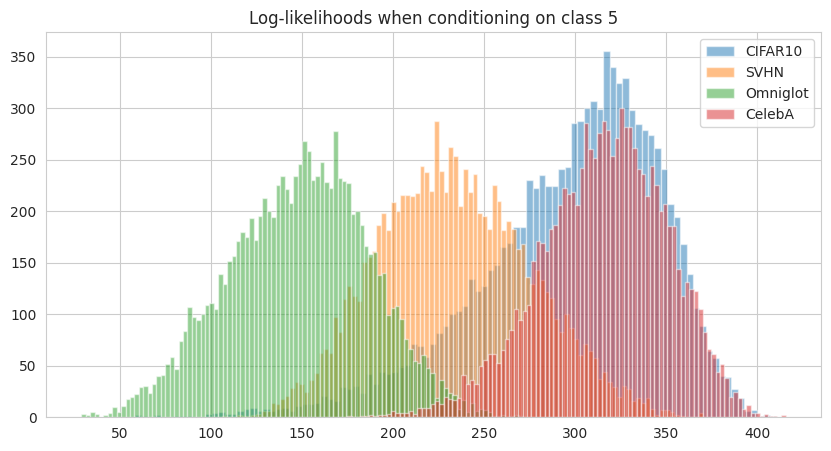

100%|██████████| 10000/10000 [01:27<00:00, 114.46it/s]


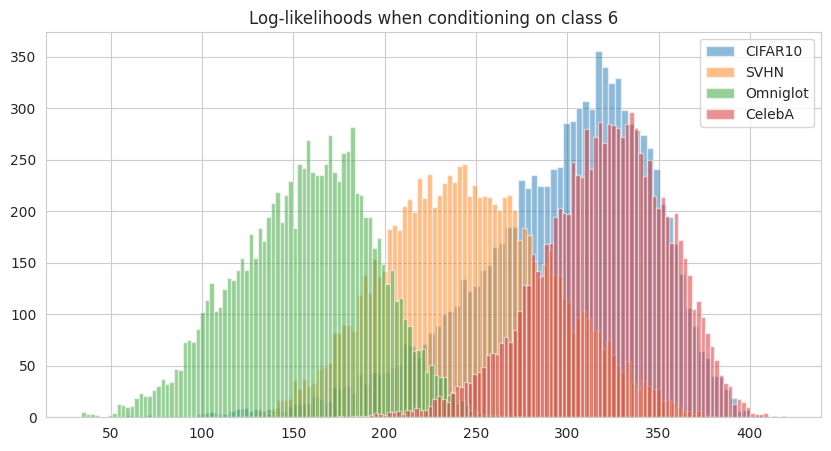

100%|██████████| 10000/10000 [01:24<00:00, 118.66it/s]


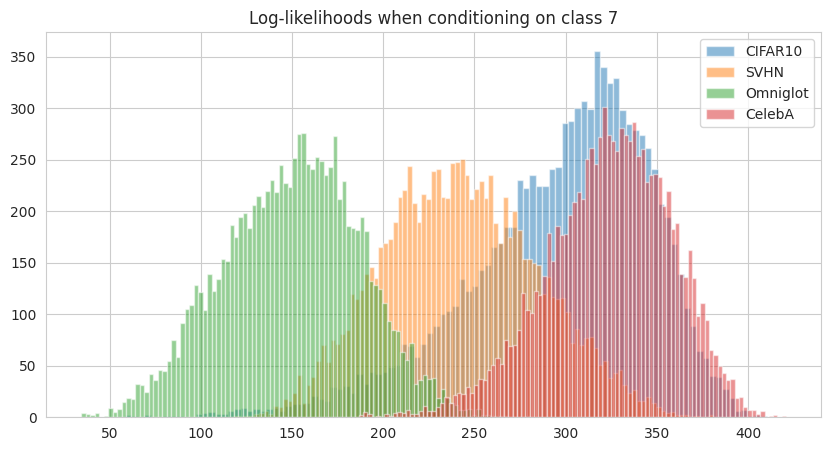

100%|██████████| 10000/10000 [01:35<00:00, 104.32it/s]


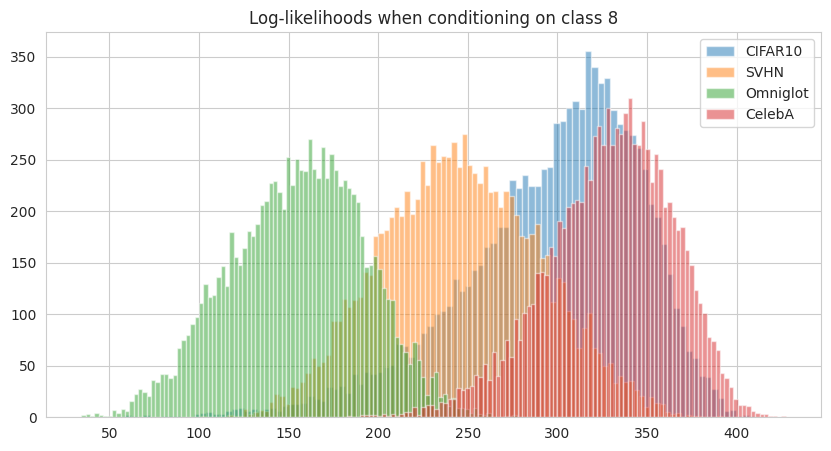

100%|██████████| 10000/10000 [01:39<00:00, 100.46it/s]


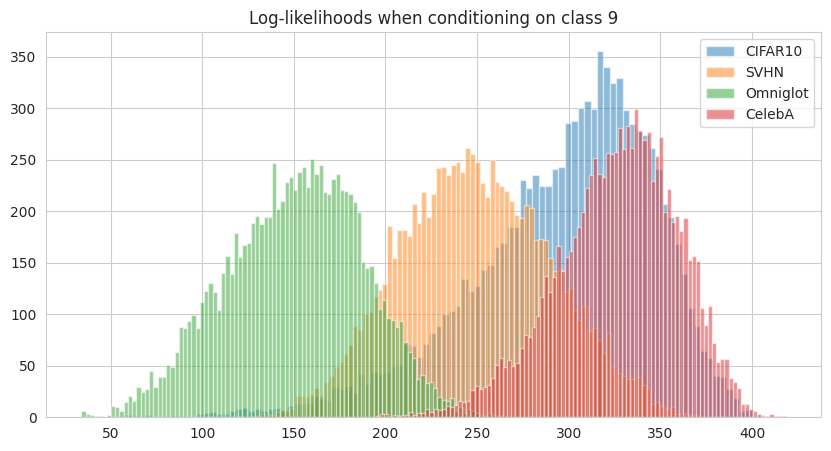

In [40]:
for cls in range(2, 10):
    
    svhn_likelihoods_cls = compute_dataset_log_likelihood(prior, svhn_test, arbitrary_cls=cls)
    omniglot_likelihoods_cls = compute_dataset_log_likelihood(prior, omniglot_test, arbitrary_cls=cls)
    celeba_likelihoods_cls = compute_dataset_log_likelihood(prior, celeba_test, arbitrary_cls=cls)

    plt.figure(figsize=(10, 5))
    plt.hist(-1*cifar_likelihoods, bins=100, alpha=0.5, label="CIFAR10")
    plt.hist(svhn_likelihoods_cls, bins=100, alpha=0.5, label="SVHN")
    plt.hist(omniglot_likelihoods_cls, bins=100, alpha=0.5, label="Omniglot")
    plt.hist(celeba_likelihoods_cls, bins=100, alpha=0.5, label="CelebA")
    plt.legend()
    plt.title("Log-likelihoods when conditioning on class {}".format(cls))
    plt.show()

# Perplexities

In [325]:
cifar_perplexities = get_dataset_perplexity(prior, cifar_test)
svhn_perplexities = get_dataset_perplexity(prior, svhn_test)
omniglot_perplexities = get_dataset_perplexity(prior, omniglot_test, arbitrary_cls=0)
celeba_perplexities = get_dataset_perplexity(prior, celeba_test, arbitrary_cls=0)

100%|██████████| 10000/10000 [00:21<00:00, 460.37it/s]


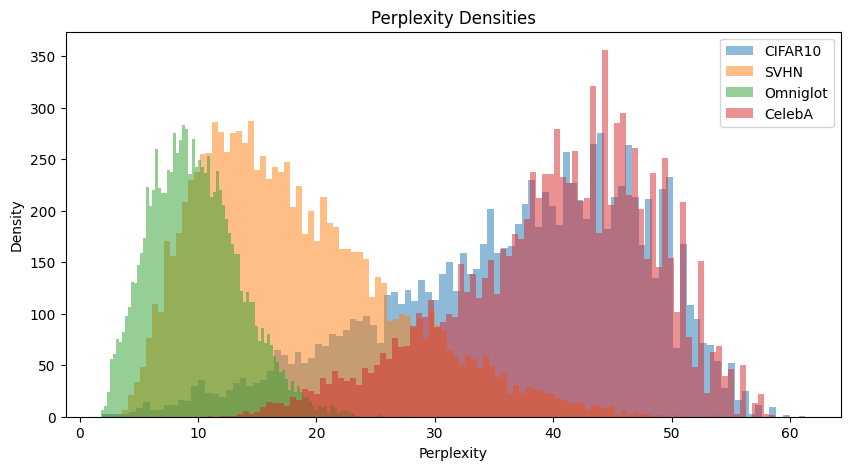

In [326]:
# plot the densities of the perplexities
plt.figure(figsize=(10, 5))
plt.hist(cifar_perplexities, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(svhn_perplexities, bins=100, alpha=0.5, label="SVHN")
plt.hist(omniglot_perplexities, bins=100, alpha=0.5, label="Omniglot")
plt.hist(celeba_perplexities, bins=100, alpha=0.5, label="CelebA")
plt.legend()
plt.title("Perplexity Densities")
plt.xlabel("Perplexity")
plt.ylabel("Density")
plt.show()

In [327]:
# compute the log of base e of the perplexities
cifar_perplexities_log = np.log(cifar_perplexities)
svhn_perplexities_log = np.log(svhn_perplexities)
omniglot_perplexities_log = np.log(omniglot_perplexities)
celeba_perplexities_log = np.log(celeba_perplexities)

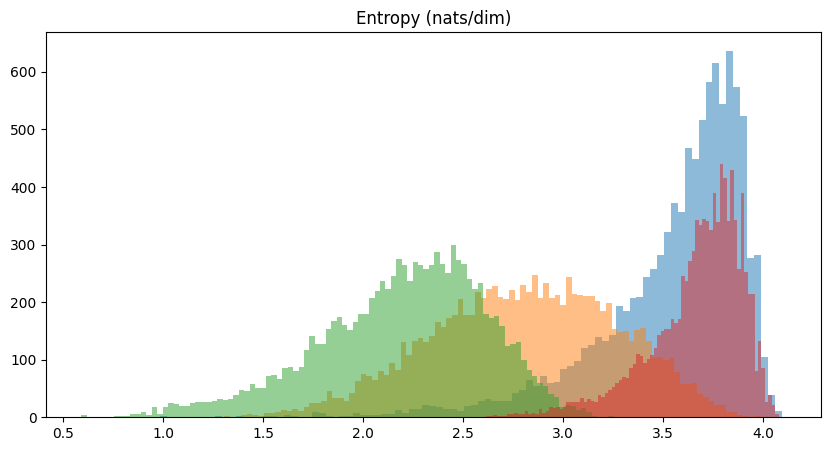

In [328]:
# plot the densities of the perplexities_log
plt.figure(figsize=(10, 5))
plt.hist(cifar_perplexities_log, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(svhn_perplexities_log, bins=100, alpha=0.5, label="SVHN")
plt.hist(omniglot_perplexities_log, bins=100, alpha=0.5, label="Omniglot")
plt.hist(celeba_perplexities_log, bins=100, alpha=0.5, label="CelebA")
plt.title("Entropy (nats/dim)")
plt.show()

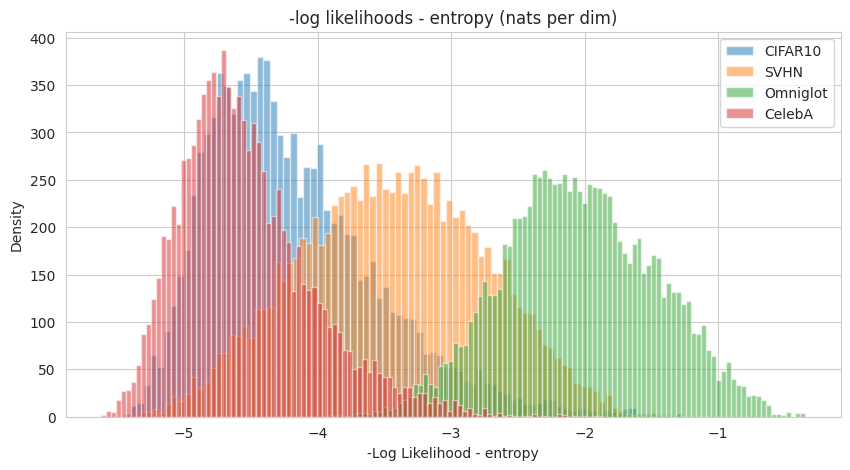

In [91]:
# plot likelihoods per pixel minus perplexities_log density
plt.figure(figsize=(10, 5))
scale = 1
plt.hist(-cifar_likelihoods_per_pixel - scale*cifar_perplexities_log, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(-svhn_likelihoods_per_pixel - scale*svhn_perplexities_log, bins=100, alpha=0.5, label="SVHN")
plt.hist(-omniglot_likelihoods_per_pixel - scale*omniglot_perplexities_log, bins=100, alpha=0.5, label="Omniglot")
plt.hist(-celeba_likelihoods_per_pixel - scale*celeba_perplexities_log, bins=100, alpha=0.5, label="CelebA")
plt.legend()
plt.xlabel("-Log Likelihood - entropy")
plt.ylabel("Density")
plt.title("-log likelihoods - entropy (nats per dim)")
plt.show()

# Distribution Distance

In [329]:
usage_probs = compute_codebook_usage_distribution(prior, cifar_train, codebook_size=prior_hparams.MODEL.INPUT_DIM)

100%|██████████| 50000/50000 [00:59<00:00, 837.15it/s]


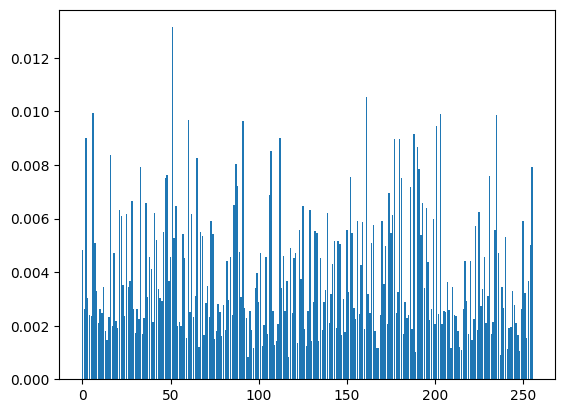

In [330]:
plt.bar(np.arange(len(usage_probs)), usage_probs)
plt.show()

In [331]:
distances_cifar_kl = extract_distances_to_probs(prior, cifar_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="kl")
distances_svhn_kl = extract_distances_to_probs(prior, svhn_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="kl")
distances_celeba_kl = extract_distances_to_probs(prior, celeba_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="kl")
distances_omniglot_kl = extract_distances_to_probs(prior, omniglot_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="kl")

100%|██████████| 10000/10000 [00:13<00:00, 733.53it/s]


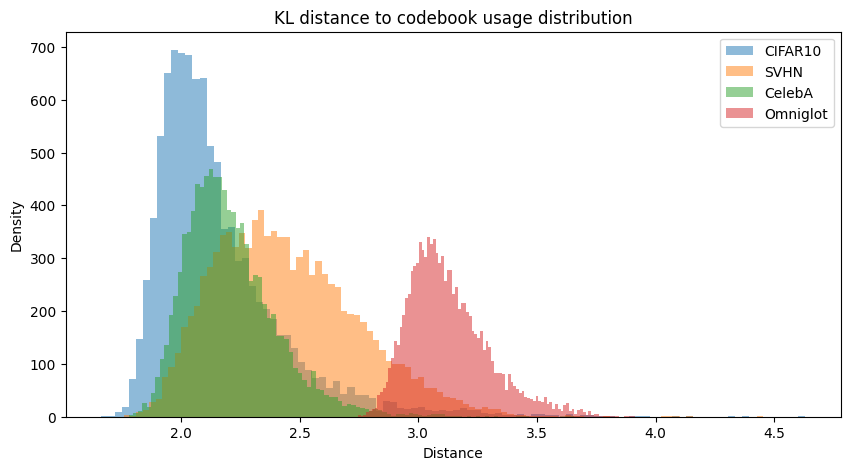

In [332]:
# plot the densities of the distances
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_kl, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_kl, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_kl, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_kl, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("KL distance to codebook usage distribution")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [333]:
distances_cifar_emd = extract_distances_to_probs(prior, cifar_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="emd")
distances_svhn_emd = extract_distances_to_probs(prior, svhn_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="emd")
distances_celeba_emd = extract_distances_to_probs(prior, celeba_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="emd")
distances_omniglot_emd = extract_distances_to_probs(prior, omniglot_test, usage_probs, prior_hparams.MODEL.INPUT_DIM, distance_func="emd")

100%|██████████| 10000/10000 [00:14<00:00, 701.65it/s]


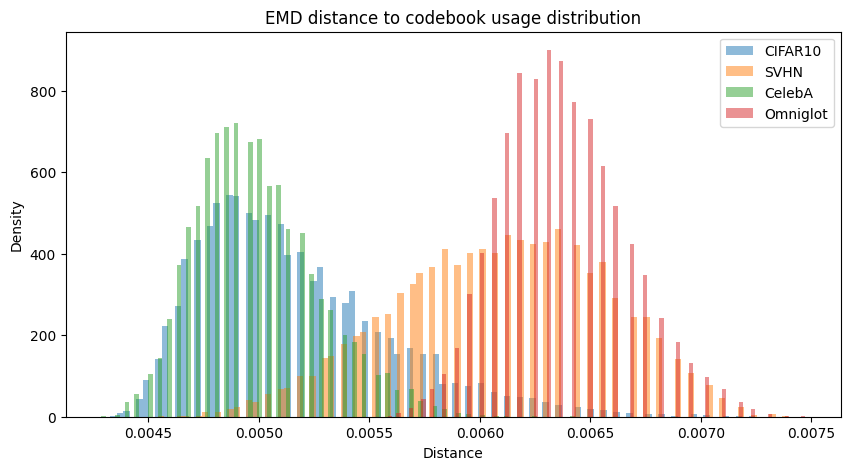

In [334]:
# plot the densities of the distances
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_emd, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_emd, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_emd, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_emd, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("EMD distance to codebook usage distribution")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [335]:
probs_2gram_ordered = compute_codebook_usage_distribution_2gram(
    prior=prior,
    dataset=cifar_train,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    order_type="ordered",
    max_size=len(cifar_train)
)

probs_2gram_unordered = compute_codebook_usage_distribution_2gram(
    prior=prior,
    dataset=cifar_train,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    order_type="unordered",
    max_size=len(cifar_train)
)

probs_2gram_bow = compute_codebook_usage_distribution_2gram(
    prior=prior,
    dataset=cifar_train,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    order_type="bag_of_words",
    max_size=len(cifar_train)
)

100%|██████████| 50000/50000 [02:06<00:00, 395.72it/s]


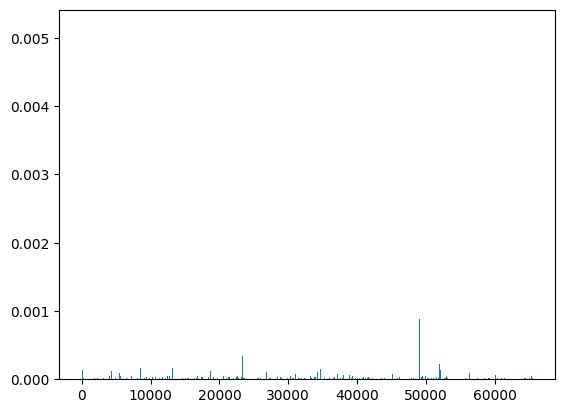

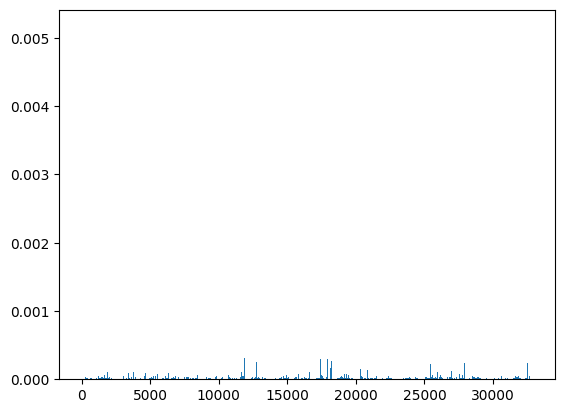

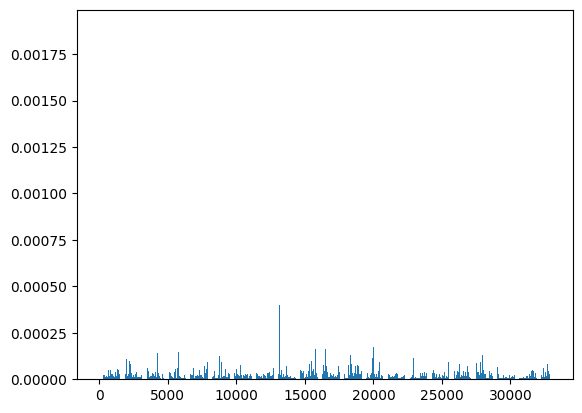

In [336]:
plt.bar(np.arange(probs_2gram_ordered.shape[0]) ,probs_2gram_ordered, label="ordered")
plt.show()

plt.bar(np.arange(probs_2gram_unordered.shape[0]), probs_2gram_unordered, label="Unordered")
plt.show()

plt.bar(np.arange(probs_2gram_bow.shape[0]), probs_2gram_bow, label="Bag of Words")
plt.show()

In [337]:
distances_cifar_kl_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior, 
    dataset=cifar_test, 
    probs=probs_2gram_ordered, 
    codebook_size=prior_hparams.MODEL.INPUT_DIM, 
    distance_func="kl",
    order_type="ordered"
)

distances_cifar_kl_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=cifar_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="unordered",
)

distances_svhn_kl_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior, 
    dataset=svhn_test, 
    probs=probs_2gram_ordered, 
    codebook_size=prior_hparams.MODEL.INPUT_DIM, 
    distance_func="kl",
    order_type="ordered"
)

distances_svhn_kl_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=svhn_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="unordered",
)

distances_celeba_kl_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_ordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="ordered"
)

distances_celeba_kl_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="unordered",
)

distances_omniglot_kl_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_ordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="ordered",
)

distances_omniglot_kl_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="unordered",
)


# compute distances to the codebook usage distribution with order_type as bag of words
distances_cifar_kl_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=cifar_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="bag_of_words",
)

distances_svhn_kl_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=svhn_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="bag_of_words",
)

distances_celeba_kl_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="bag_of_words",
)

distances_omniglot_kl_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="kl",
    order_type="bag_of_words",
)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/nazir/wall_maria/rare/vae/PyTorch-VAE/likelihood.py:346: RuntimeWarning: invalid value encountered in divide
  
  1%|          | 55/10000 [00:00<00:18, 546.10it/s]/home/nazir/wall_maria/rare/vae/PyTorch-VAE/likelihood.py:346: RuntimeWarning: divide by zero encountered in divide
  
100%|██████████| 10000/10000 [00:36<00:00, 276.87it/s]


/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

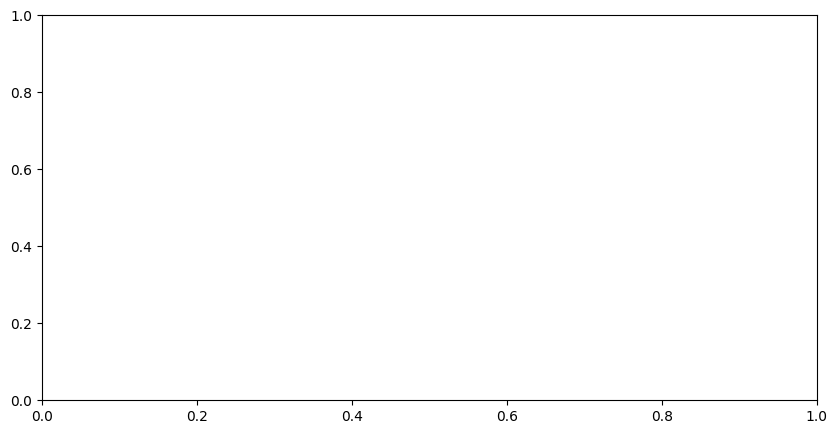

In [338]:
# plot the densities of the distances for the ordered 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_kl_2gram_ordered, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_kl_2gram_ordered, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_kl_2gram_ordered, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_kl_2gram_ordered, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("KL distance to codebook usage distribution (2-gram ordered)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

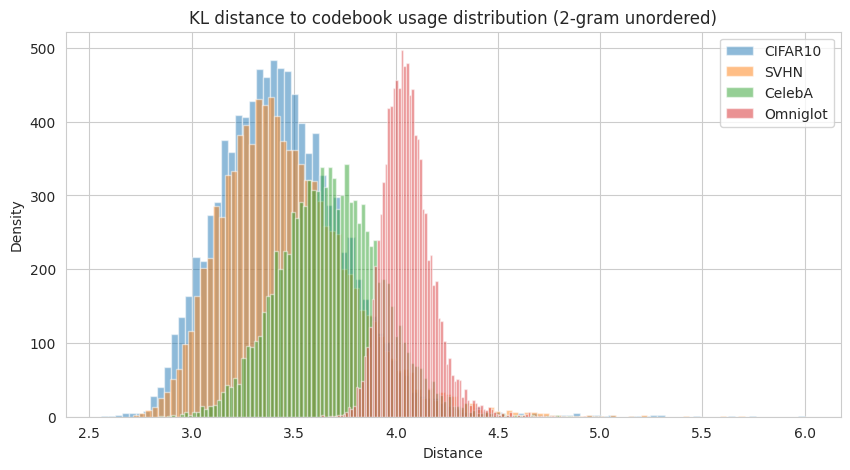

In [ ]:
# plot the densities of the distances for the unordered 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_kl_2gram_unordered, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_kl_2gram_unordered, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_kl_2gram_unordered, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_kl_2gram_unordered, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("KL distance to codebook usage distribution (2-gram unordered)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

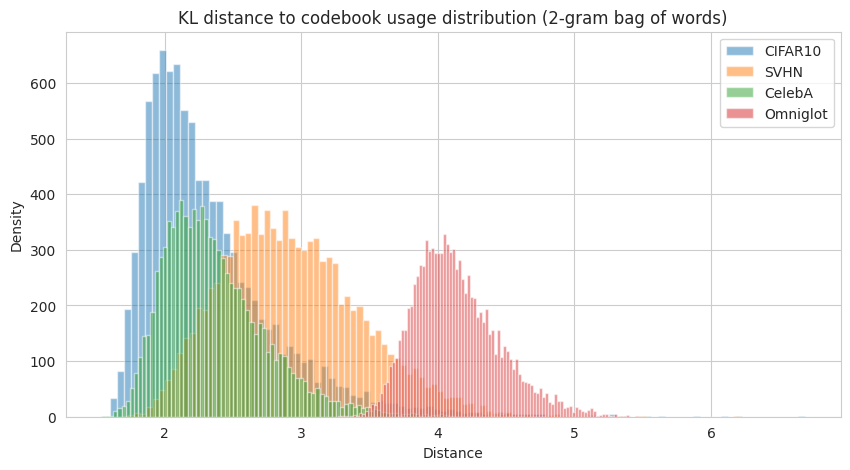

In [ ]:
# plot the densities of the distances for the bag of words 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_kl_2gram_bow, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_kl_2gram_bow, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_kl_2gram_bow, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_kl_2gram_bow, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("KL distance to codebook usage distribution (2-gram bag of words)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [ ]:
distances_cifar_emd_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior, 
    dataset=cifar_test, 
    probs=probs_2gram_ordered, 
    codebook_size=prior_hparams.MODEL.INPUT_DIM, 
    distance_func="emd",
    order_type="ordered"
)

distances_cifar_emd_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=cifar_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="unordered",
)

distances_svhn_emd_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior, 
    dataset=svhn_test, 
    probs=probs_2gram_ordered, 
    codebook_size=prior_hparams.MODEL.INPUT_DIM, 
    distance_func="emd",
    order_type="ordered"
)

distances_svhn_emd_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=svhn_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="unordered",
)

distances_celeba_emd_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_ordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="ordered"
)

distances_celeba_emd_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="unordered",
)

distances_omniglot_emd_2gram_ordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_ordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="ordered",
)

distances_omniglot_emd_2gram_unordered = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_unordered,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="unordered",
)


# compute distances to the codebook usage distribution with order_type as bag of words
distances_cifar_emd_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=cifar_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="bag_of_words",
)

distances_svhn_emd_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=svhn_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="bag_of_words",
)

distances_celeba_emd_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=celeba_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="bag_of_words",
)

distances_omniglot_emd_2gram_bow = extract_distances_to_probs_2gram(
    prior=prior,
    dataset=omniglot_test,
    probs=probs_2gram_bow,
    codebook_size=prior_hparams.MODEL.INPUT_DIM,
    distance_func="emd",
    order_type="bag_of_words",
)

100%|██████████| 10000/10000 [00:30<00:00, 323.89it/s]


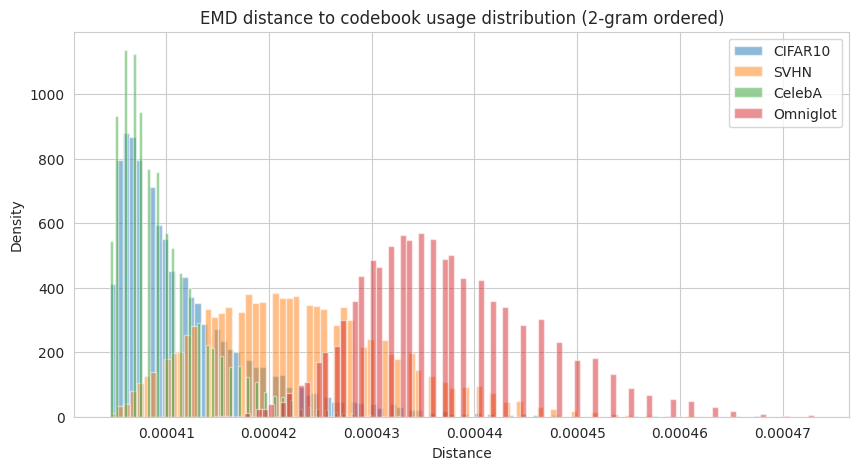

In [ ]:
# plot the densities of the distances for the ordered 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_emd_2gram_ordered, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_emd_2gram_ordered, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_emd_2gram_ordered, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_emd_2gram_ordered, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("EMD distance to codebook usage distribution (2-gram ordered)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

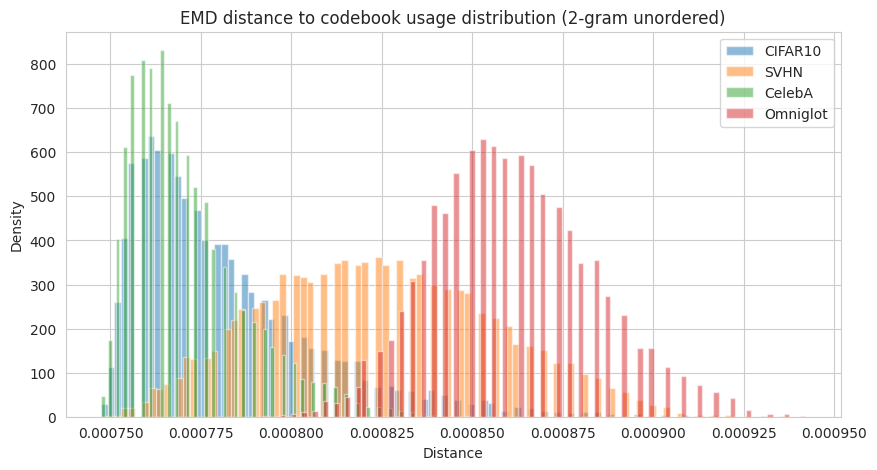

In [ ]:
# plot the densities of the distances for the unordered 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_emd_2gram_unordered, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_emd_2gram_unordered, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_emd_2gram_unordered, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_emd_2gram_unordered, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("EMD distance to codebook usage distribution (2-gram unordered)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

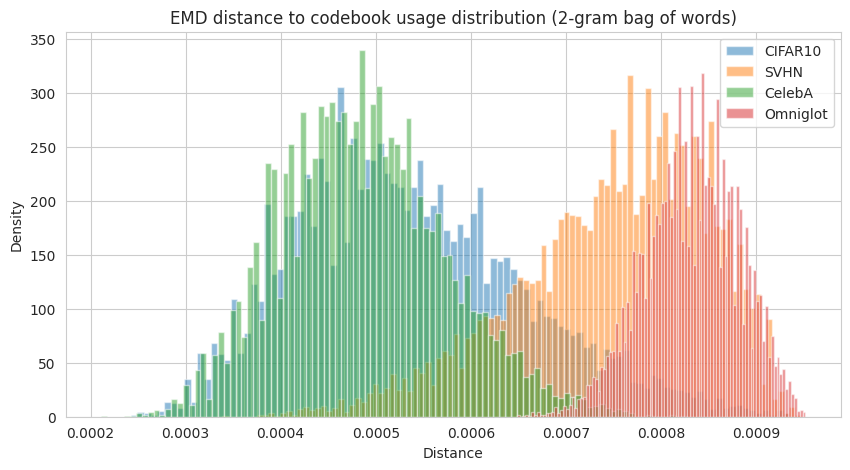

In [ ]:
# plot the densities of the distances for the bag of words 2-gram
plt.figure(figsize=(10, 5))
plt.hist(distances_cifar_emd_2gram_bow, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(distances_svhn_emd_2gram_bow, bins=100, alpha=0.5, label="SVHN")
plt.hist(distances_celeba_emd_2gram_bow, bins=100, alpha=0.5, label="CelebA")
plt.hist(distances_omniglot_emd_2gram_bow, bins=100, alpha=0.5, label="Omniglot")
plt.legend()
plt.title("EMD distance to codebook usage distribution (2-gram bag of words)")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()